<a href="https://colab.research.google.com/github/mgt412/course_notebooks/blob/master/MGT412_Lecture_10_MonteCarlo_OptionPricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 10: Monte Carlo Option Pricing

In [0]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

## Monte Carlo simulation (static, plain vanilla call & put)

1. Simulate a large number ($N$) of terminal stock prices.
2. Compute the option value for each terminal stock price.
3. Take the average across all $N$.
4. The method is simple and intuitive. It requires two assumptions:
  * The option is European (only exercised at maturity)
  * The option payoff depends only on final stock prices.
5. Useful method for plain vanilla calls and puts.

In [0]:
# initialize values
T, N, S, r, sigma, K, typeEA, typeCP = 2, 2000, 100, 0.03, 0.20, 110, 'European', 'call'

def BlackScholes(T,S,K,sigma,r,typeCP):
  d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
  d2=d1-sigma*np.sqrt(T)
  
  call=S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
  put = K*np.exp(-r*T)*norm.cdf(-d2)- S*norm.cdf(-d1)
  
  if typeCP=='call':
    return call
  else:
    return put

In [0]:
def montecarlo(T,N,S,r,sigma,K,typeCP):

    if typeCP=="call":
        typeCP=1
    else:
        typeCP=-1

    z = npr.randn(N)
    # simulate index level at maturity
    ST = S*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*z)
    # calculate payoff at maturity
    OptionT= np.maximum(typeCP*(ST - K), 0)
    option = np.exp(-r*T)*OptionT.mean()
    return option

### How does Monte Carlo stack up against Black-Scholes?

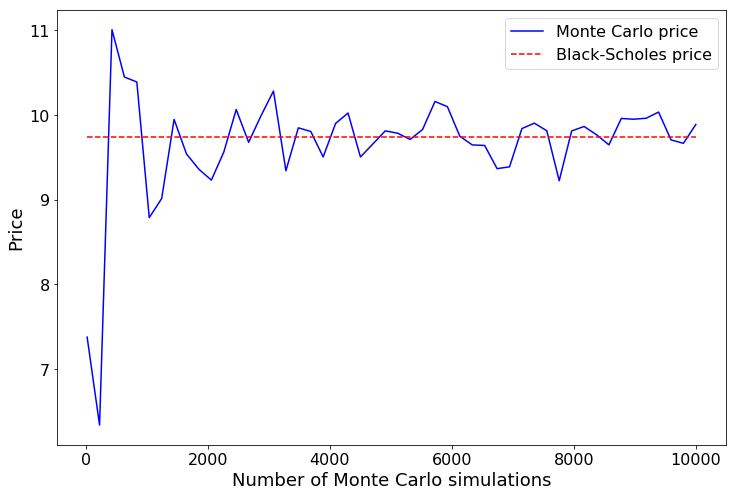

In [20]:
N_space=np.linspace(20,10000) # number of simulations

binomial_space=[montecarlo(T,int(x),S,r,sigma,K, "call") for x in N_space]
BS_space=[BlackScholes(T,S,K,sigma,r,'call') for x in N_space]

fig=plt.figure(figsize=(12,8))
plt.plot(N_space,binomial_space,label='Monte Carlo price',c='b')
plt.plot(N_space, BS_space,label='Black-Scholes price',c='r',ls='--')
plt.xlabel('Number of Monte Carlo simulations',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16,loc='best')

## Monte Carlo simulation (dynamic, i.e., Asian options)

#### Asian options
Let $A(0;T)$ be the average price of stock S between zero and $T$.

An Asian call option pays off at T:
$$ AC=\max\left(A\left(0,T\right)-K,0\right). $$

An Asian put option pays off at T:
$$ AP=\max\left(K-A\left(0,T\right),0\right). $$


1. Asian option payoffs do not only depend on the final stock price.
2. To price them, we need to simulate the entire path of the stock price.

In [0]:
def montecarlo_dynamic(T,N,steps,S,r,sigma,K,typeCP):

    if typeCP=="call":
        typeCP=1
    else:
        typeCP=-1

    dt=np.float(T)/steps

    SPath=np.zeros((steps+1,N)) # matrix of N paths
    
    SPath[0]=S # first value is S for all paths
    for t in range(1,steps+1):
        z = npr.randn(N) # random noise for all paths at time t
        SPath[t]=SPath[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*z)
        
    # calculate payoff at maturity
    OptionT= np.maximum(typeCP*(SPath.mean(axis=0)-K), 0)
    option = np.exp(-r*T)*OptionT.mean()
    return option

## Least-Squares Monte Carlo (for American options)

To price American options, you need to consider early exercise: 

You cannot simply "simulate" a stock path since intermediate exercise times matter.

* American options can be exercised at any moment during their life.
* In practice, we only look at exercises at the specific steps in the tree (more like a Bermudan option).
* You need to account for the exercise possibility at any node in the tree.
*  The value of a (call) option is:
	\begin{equation}
	V_{0}=\max_{\tau\in\left\{0,\Delta t, 2\Delta t,....T\right\}} e^{-rT} \mathbb{E}\left[\max\left(S_\tau-K,0\right)\right]
	\end{equation}
* That is, the value of the option is the **maximum over all possible exercise dates.**

### Recursive framework

* The formula before can be cast into a recursive framework. 
* At each potential exercise date $t$, the value of the option is the maximum of two choices: 
	1.  the value of immediate exercise
	2.  the discounted expected value of the option at the next possible exercise moment.


\begin{equation*}
	V_{t}\left(S_t\right)=\max\left[\max\left(S_t-K,0\right), e^{-r\Delta t} \mathbb{E}V_{t+\Delta t}\left(S_{t+\Delta t}\right)\right]
	\end{equation*}

### Simplest idea:

1. One can work backwards through this equation to get $V_{0}$.
2. To get the option value at $t$, we need an \textit{expectation} of the value at $t+1$.
3. One solution would be to look at the value of the option on that particular path.
4.  However, that would imply perfect foresight, i.e., not really an expectation.

### Refined solution (no perfect foresight):


1. A better solution is to regress all continuation values, across \textbf{all paths} on functions of the stock price:
	\begin{equation*}
	V_{t+1,i}\left(S_{t+1,i}\right)e^{-r\Delta t}=\beta_0+\beta_1 S_{t,i} + \beta_2 S^2_{t,i} + ... +\text{error}
	\end{equation*}
2. The fitted values of the regression are used as the expectation.
3.  You need to do as many regressions as steps in the tree. 
4. The number of observations is equal to the number of paths.
5. Hence, the Least Squares Monte Carlo name of the approach.

### Algorithm

1. Define auxiliary variables

In [0]:
if typeCP=="call":
  typeCP=1
else:
  typeCP=-1
  
steps=50

# possible exercise types (discrete, not continuous)  
dt = np.float(T) / steps
df = np.exp(-r * dt)

2. Simulate the stock price paths

In [0]:
SPath = np.zeros((steps + 1, N)) # empty path variables
SPath[0] = S # first price is given

z=npr.randn(steps,N) # generate random variables for each step and path
for t in range(1, steps + 1): # fill stock prices using random variables
  SPath[t] = SPath[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *z[t-1])

3. Compute immediate exercise values for **all** nodes in the tree.

In [0]:
# case-based calculation of payoff
h = np.maximum(typeCP*(SPath - K), 0)

4. Copy the exercise values into a **value** matrix (to not over-write them).

In [0]:
V = np.copy(h)

5. For each level in the tree, regress discounted continuation values on stock prices polynomials:

* Save the fitted continuation values of the regression ($C$);
* If the continuation value $C$ is larger than the immediate exercise value $h$, update the value matrix with the (discounted) continuation value.
* If the continuation value $C$ is smaller than the immediate exercise value $h$, update the value matrix with the immediate exercise value.

In [0]:
for t in range(steps - 1, 0, -1):
  reg = np.polyfit(SPath[t], V[t + 1] * df, 7)
  C = np.polyval(reg, SPath[t])
  V[t] = np.where(C > h[t], V[t + 1] * df, h[t])

6. The option value is the discounted average over all paths of the continuation values at the first possible exercise moment.

In [0]:
option = df * 1 / N * np.sum(V[1])

### LSM in a single function

In [0]:
def LSM_montecarlo(T,N,steps,S,r,sigma,K, typeCP):

    if typeCP=="call":
        typeCP=1
    else:
        typeCP=-1
    
    dt = np.float(T) / steps
    df = np.exp(-r * dt)
    
    # simulation of index levels
    SPath = np.zeros((steps + 1, N))
    SPath[0] = S
    z=npr.randn(steps,N)
    for t in range(1, steps + 1):
        SPath[t] = SPath[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *z[t-1])

    # case-based calculation of payoff
    h = np.maximum(typeCP*(SPath - K), 0)
    # LSM algorithm
    V = np.copy(h)
    for t in range(steps - 1, 0, -1):
        reg = np.polyfit(SPath[t], V[t + 1] * df, 7)
        C = np.polyval(reg, SPath[t])
        V[t] = np.where(C > h[t], V[t + 1] * df, h[t])
    # MCS estimator
    option = df * 1 / N * np.sum(V[1])
    return option

## Applications for exotic options

**Lookback option** A *lookback* call option pays the difference between the spot price at expiration and the minimum spot price over the term of the contract, if this difference is larger than zero. At maturity, the value of the option is:

\begin{equation}
\textit{Lookback}_T=\max \left(0, S_T-\min_{0\leq t \leq T} S_t\right).
\end{equation}

Write a Python function to value the *lookback* call option using a **binomial tree**. 

1. The function takes as inputs: the stock price at $t=0$, i.e., $S_0$, the stock volatility $\sigma$, the number of steps in the tree $N$, the risk-free rate $r$ (yearly, continuously compounded) and the maturity $T$ (in years). 
2. Use the Cox-Ross-Rubinstein model to compute the up and down steps, i.e., $u=\exp\left(\sigma \sqrt{\frac{T}{N}}\right)$ and $ud=1$. 
3. The output of the function is the price of the lookback option. 
4. Numerical example: S0=50, $\sigma$=0.25, N=10, r=0.02, T=1.
5. Can you value this option via Monte Carlo simulation of the final price $S_T$? Discuss. 

In [0]:
def lookback(T,N,S0,r,sigma):

    ### Preliminary steps
    dt=np.float(T)/N # step size
    u=np.exp(sigma*np.sqrt(dt)) # up and down steps
    d=1/u
    p=(np.exp(r*dt)-d)/(u-d) # risk-neutral probability
    
    # Path generator (2**N paths, N steps)
    Paths=np.zeros([N+1,2**N]) # initialize paths
    Paths[0,:]=S0 # first element on path is S0

    for j in range(N,0,-1): # fill in all (2^N) possible paths in a N x 2^N matrix
            temp=2**(N-j)*([1 for i in range(0,2**(j-1))],[0 for i in range(0,2**(j-1))])
            print (temp, "\n")
            Paths[N-j+1,:]=[val for s in temp for val in s]
            print (Paths, "\n")

    # risk-neutral probabilities
    RN_Probs=p**Paths[1:].sum(axis=0)*(1-p)**(N-Paths[1:].sum(axis=0))

    # fill the paths matrix with up and down steps
    Paths[1:]=Paths[1:]*(u-d)+d

    for i in range(1,np.size(Paths,axis=0)):
        Paths[i,:]=Paths[i-1,:]*Paths[i,:]

    ### Option price
    option_path_values=Paths[-1,:]-Paths.min(axis=0) # option value for each path

    option=np.dot(option_path_values,RN_Probs) # scalar product of value and path probability

    return option_path_values, option

In [35]:
lookback(1,3,100,0.01,0.25)

([1, 1, 1, 1], [0, 0, 0, 0]) 

[[100. 100. 100. 100. 100. 100. 100. 100.]
 [  1.   1.   1.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]] 

([1, 1], [0, 0], [1, 1], [0, 0]) 

[[100. 100. 100. 100. 100. 100. 100. 100.]
 [  1.   1.   1.   1.   0.   0.   0.   0.]
 [  1.   1.   0.   0.   1.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]] 

([1], [0], [1], [0], [1], [0], [1], [0]) 

[[100. 100. 100. 100. 100. 100. 100. 100.]
 [  1.   1.   1.   1.   0.   0.   0.   0.]
 [  1.   1.   0.   0.   1.   1.   0.   0.]
 [  1.   0.   1.   0.   1.   0.   1.   0.]] 



(array([54.18958056, 15.52740254, 15.52740254,  0.        , 28.96785234,
         0.        , 11.63399289,  0.        ]), 14.46608334291325)

**Power option** A *power* call option pays a (positive) power of the difference between the spot price at expiration and a strike price, if this difference is larger than zero. At maturity, the value of the option is:
\begin{equation}
\textit{Power}_{T,k}=\max \left(0, \left[S_T-K\right]^{k}\right).
\end{equation}

1. Write a Python function to value the power call option using a binomial tree. 
2. The function takes as inputs: the stock price at $t=0$, i.e., $S_0$, the stock volatility $\sigma$, the number of steps in the tree $N$, the strike price $K$, the power coefficient $k$, the risk-free rate $r$ (yearly, continuously compounded) and the maturity $T$ (in years). 
3. Use the Cox-Ross-Rubinstein model to compute the up and down steps, i.e., $u=\exp\left(\sigma \sqrt{\frac{T}{N}}\right)$ and $ud=1$. 
4. The output of the function is the price of the lookback option. 
5. Numerical example: S0=50, sigma=0.25, N=10, r=0.02, T=1, K=50, k=2
6. How would you evaluate a plain vanilla call option using the function you just created? 
7. Can you evaluate the power option using Monte Carlo simulations? Explain.

In [0]:
def power(T,N,S0,K,k,r,sigma):
    
    ### Preliminary steps
    dt=np.float(T)/N # step size
    u=np.exp(sigma*np.sqrt(dt)) # up and down steps
    d=1/u
    p=(np.exp(r*dt)-d)/(u-d) # risk-neutral probability

    #### Path generator
    Paths=np.zeros([N+1,2**N]) # initialize paths
    Paths[0,:]=S0 # first element on path is S0

    for j in range(N,0,-1): # fill in all (2^N) possible paths in a N x 2^N matrix
        temp=2**(N-j)*([1 for i in range(0,2**(j-1))],[0 for i in range(0,2**(j-1))])
        Paths[N-j+1,:]=[val for s in temp for val in s]

    # risk-neutral probabilities
    RN_Probs=p**Paths[1:].sum(axis=0)*(1-p)**(N-Paths[1:].sum(axis=0))

    # fill the paths matrix with up and down steps
    Paths[1:]=Paths[1:]*(u-d)+d

    for i in range(1,np.size(Paths,axis=0)):
        Paths[i,:]=Paths[i-1,:]*Paths[i,:]

    ### Option price
    option_path_values=np.maximum(0,(Paths[-1,:]-K)**k) # option value for each path

    option=np.exp(-r*T)*np.dot(option_path_values,RN_Probs) # scalar product of value and path probability

    return option_path_values, Paths, option

In [0]:
def power2(T,N,S,K,k,r,sigma):

    dt=np.float(T)/N # step size
    u=np.exp(sigma*np.sqrt(dt)) # up and down steps
    d=1/u
    p=(np.exp(r*dt)-d)/(u-d) # risk-neutral probabilities

    ST=np.zeros(N+1) # Final stock prices vector
    option=np.zeros(N+1) # option price vector

    for i in range(0,N+1):
        ST[i]=S*u**(N-i)*d**i # Fill in terminal stock prices
        option[i]=max((ST[i]-K)**k,0) # Fill in terminal option prices
    
    for i in range(N-1,-1,-1):
        for j in range(0,i+1):
            option[j]=np.exp(-r*dt)*(p*option[j]+(1-p)*option[j+1])

    return option[0]

In [38]:
power(1,5,100,150,3,0.10,0.25)[2], power2(1,5,100,150,3,0.10,0.25) # two ways to solve the same problem

(784.3374468302424, 784.337446830242)